<a href="https://colab.research.google.com/github/maktaurus/ML-Work/blob/main/Tensorflow/Variational_AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import glob
import pandas as pd
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import layers
from tensorflow.keras.metrics import Accuracy,TruePositives,TrueNegatives,FalsePositives,FalseNegatives,Recall,Precision,AUC
import zipfile,os

import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.regularizers import L2
import tensorflow_datasets as tfds
# !pip install -U tensorboard-plugin-profile
# !pip install -q wandb
# import wandb

In [2]:
(x1, y1), (x2, y2) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
data = np.concatenate([x1,x2],axis=0)
data = np.expand_dims(data,axis=-1).astype(np.float32) / 255

In [4]:
data.shape

(70000, 28, 28, 1)

In [12]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        return z_mean + tf.exp(0.5 * z_log_var) * tf.random.normal(tf.shape(z_mean))

In [13]:
encoder_input = tf.keras.Input(shape=(28,28,1))
x = layers.Conv2D(32, 3, strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

mean = layers.Dense(2,)(x)
log_var = layers.Dense(2,)(x)
z = Sampling()([mean, log_var])

encoder_model = tf.keras.Model(encoder_input, [z, mean, log_var], name="encoder")
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 14, 14, 32)           320       ['input_6[0][0]']             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d_8[0][0]']            
                                                                                                  
 flatten_4 (Flatten)         (None, 3136)                 0         ['conv2d_9[0][0]']            
                                                                                            

Decoder Block

In [14]:
decoder_input = tf.keras.Input(shape=(2,))
x = layers.Dense(7 * 7 * 64, activation="relu")(decoder_input)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)
decoder_output = layers.Conv2DTranspose(1, 3, strides=1, activation="sigmoid", padding="same")(x)

decoder_model = tf.keras.Model(decoder_input, decoder_output, name="decoder")
decoder_model.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_15 (Dense)            (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         289 

In [15]:
def custom_loss(y_true, y_pred, mean, log_var):
    loss_recons = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred), axis=(1,2)))
    loss_reg = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var)), axis=1))
    return loss_recons + loss_reg

In [18]:
vae_input = tf.keras.Input(shape=(28,28,1))
z, mean, log_var = encoder_model(vae_input)
reconstructed = decoder_model(z)
vae = tf.keras.Model(vae_input, reconstructed, name="vae")
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65089     
                                                                 
Total params: 134165 (524.08 KB)
Trainable params: 134165 (524.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
EPOCHS = 10

In [21]:
class VAE(tf.keras.Model):
  def __init__(self, encoder_model, decoder_model, custom_loss):
    super(VAE, self).__init__()
    self.encoder = encoder_model
    self.decoder = decoder_model
    self.custom_loss = custom_loss
    self.loss_tracker = tf.keras.metrics.Mean(name="loss")

  @property
  def metrics(self):
    return [self.loss_tracker]

  def train_step(self, x_batch):
    with tf.GradientTape() as tape:
      z, mean, log_var = self.encoder(x_batch)
      reconstructed = self.decoder(z)
      loss = self.custom_loss(x_batch, reconstructed, mean, log_var)
    partial_derivatives = tape.gradient(loss, self.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivatives,self.trainable_weights))

    self.loss_tracker.update_state(loss)
    return {"loss": self.loss_tracker.result()}

In [22]:
mymodel = VAE(encoder_model, decoder_model, custom_loss)
mymodel.compile(optimizer=OPTIMIZER)
mymodel.fit(data, epochs=EPOCHS, batch_size=128)

Epoch 1/10
547/547 [==============================] - 12s 9ms/step - loss: 210.9445
Epoch 2/10
547/547 [==============================] - 5s 9ms/step - loss: 175.1701
Epoch 3/10
547/547 [==============================] - 5s 8ms/step - loss: 164.0563
Epoch 4/10
547/547 [==============================] - 4s 8ms/step - loss: 160.9190
Epoch 5/10
547/547 [==============================] - 5s 9ms/step - loss: 159.2346
Epoch 6/10
547/547 [==============================] - 4s 8ms/step - loss: 157.9200
Epoch 7/10
547/547 [==============================] - 4s 8ms/step - loss: 156.9912
Epoch 8/10
547/547 [==============================] - 5s 8ms/step - loss: 156.0930
Epoch 9/10
547/547 [==============================] - 5s 9ms/step - loss: 155.5143
Epoch 10/10
547/547 [==============================] - 5s 9ms/step - loss: 154.9531


In [28]:
mymodel.layers[1].summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_15 (Dense)            (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         289 

In [29]:
gridx = np.linspace(-1,1,16)
gridy = np.linspace(-1,1,16)
n = 16

In [34]:
print(gridx, gridy)

[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ] [-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]


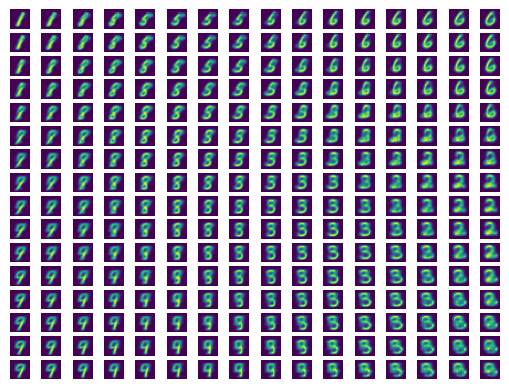

In [37]:
i = 0
for x in gridx:
  for y in gridy:
    plt.subplot(n,n,i+1)
    pred = mymodel.decoder.predict(np.array([[x,y]]),verbose=0)
    plt.imshow(pred[0])
    plt.axis("off")
    i += 1